In [162]:
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim.corpora as corpora
import pprint
import spacy
import pyLDAvis 
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 're', 'youre', 'use', 'shouldnt', 'this', 'just', 'like', 'the'])

In [163]:
import warnings
warnings.filterwarnings("ignore")

In [164]:
!ls analysis/

elon_all_tweets.csv


In [165]:
elon = pd.read_csv("analysis/elon_all_tweets.csv")
elon.shape

(15892, 21)

In [166]:
def is_reply(text):
    text = text.lstrip()
    if text[0] == "@":
        return 1
    else: 
        return 0

In [167]:
elon = elon[elon.columns[:4]]
elon.head()

,url,date,content,renderedContent
0,https://twitter.com/elonmusk/status/1520269132...,2022-04-30 05:09:40+00:00,@pmarca I’ve talked to many more people who we...,@pmarca I’ve talked to many more people who we...
1,https://twitter.com/elonmusk/status/1520230701...,2022-04-30 02:36:58+00:00,"@pmarca Drugs, alcohol especially, have played...","@pmarca Drugs, alcohol especially, have played..."
2,https://twitter.com/elonmusk/status/1520222336...,2022-04-30 02:03:44+00:00,@PPathole @pmarca A friend just emailed me abo...,@PPathole @pmarca A friend just emailed me abo...
3,https://twitter.com/elonmusk/status/1520218243...,2022-04-30 01:47:28+00:00,@PPathole @pmarca I have not heard bad things ...,@PPathole @pmarca I have not heard bad things ...
4,https://twitter.com/elonmusk/status/1520211168...,2022-04-30 01:19:21+00:00,@pmarca Wellbutrin is way worse than Adderall ...,@pmarca Wellbutrin is way worse than Adderall ...


In [168]:
elon['replies'] = elon['content'].map(is_reply)
# elon.head()

In [169]:
elon.replies.value_counts()

1    11627
0     4265
Name: replies, dtype: int64

In [170]:
elon.replies.value_counts(normalize=True)

1    0.731626
0    0.268374
Name: replies, dtype: float64

In [171]:
elon['year'] = elon['date'].map(lambda x: x[:4])
elon['month'] = elon['date'].map(lambda x: x[5:7])

In [172]:
elon.sort_values(by='year', inplace=True)

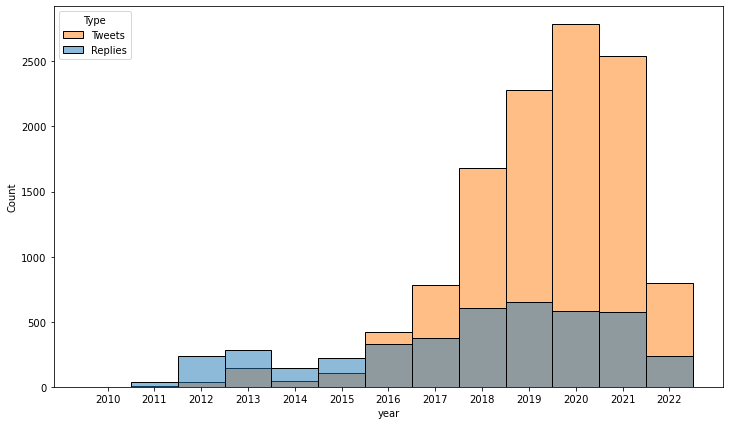

In [173]:
ax = plt.subplots(1,1,figsize=(12,7))
sns.histplot(data=elon, x='year', hue='replies', legend=False)
plt.legend(title='Type', loc='upper left', labels=['Tweets', 'Replies'])

plt.show()

In [184]:

def remove_word(text, word):
    return re.sub(word, ' ', text, flags=re.I)

def clean_text(text, remove_hashtag = False, suppress_punctuation = False, remove_stopwords=False):
    """
    returns cleaned text
    """
    # remove mentions
    
    
    text = re.sub('@[a-zA-Z0-9_]+', '', text, flags=re.I)
    # REMOVE LINKS
    text =re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', text,
                 flags=re.I)
    # remove spl characters and numbers and supress #
    
    if suppress_punctuation:
        text = re.sub('[^A-Za-z\ #]+', '', text, flags=re.I|re.M)
    else:
        text = re.sub('[^A-Za-z\ ?!.#]+', '', text, flags=re.I|re.M)
    if remove_hashtag:
        text = re.sub('#', ' ', text)
    text = remove_word(text, "amp")
    text = text.strip().lower()
    if remove_stopwords:
        temp = [w for w in nltk.word_tokenize(text) if w not in stop_words]
        text = ' '.join(temp)    
    return text


    

In [185]:
stop_words

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [186]:
elon['clean_text'] = elon.content.map(lambda x: clean_text(x, True, True, True))

In [187]:
elon_tweets = elon[elon['replies']==0]['clean_text'].to_list()
elon_replies = elon[elon['replies']==1]['clean_text'].to_list()
elon_tweets = [nltk.word_tokenize(s) for s in elon_tweets]
elon_replies = [nltk.word_tokenize(s) for s in elon_replies]

In [188]:
# elon_tweets

In [189]:
# elon_replies

In [206]:
id2word = corpora.Dictionary(elon_tweets+elon_replies)
corpus = [id2word.doc2bow(text) for text in elon_tweets+elon_replies]
num_topics = 5
# corpus
lda_model_tweets = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

In [207]:
len(id2word)

13690

In [208]:
# id2wordre = corpora.Dictionary(elon_replies)
# corpusre = [id2word.doc2bow(text) for text in elon_replies]
# num_topics = 10
# # corpus
# lda_model_replies = gensim.models.LdaMulticore(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=num_topics)

In [209]:
print('Topics:')
for topic in lda_model_tweets.print_topics():
    print(topic)
    print('-'*10)

Topics:
(0, '0.008*"great" + 0.007*"tesla" + 0.006*"model" + 0.006*"good" + 0.006*"people" + 0.006*"would" + 0.005*"much" + 0.005*"also" + 0.005*"one" + 0.004*"exactly"')
----------
(1, '0.015*"tesla" + 0.008*"good" + 0.007*"yes" + 0.005*"work" + 0.005*"high" + 0.005*"maybe" + 0.005*"great" + 0.004*"next" + 0.004*"also" + 0.004*"true"')
----------
(2, '0.008*"yes" + 0.008*"tesla" + 0.006*"haha" + 0.006*"would" + 0.005*"thanks" + 0.004*"true" + 0.004*"year" + 0.004*"good" + 0.004*"rocket" + 0.004*"new"')
----------
(3, '0.012*"tesla" + 0.005*"yeah" + 0.005*"car" + 0.005*"years" + 0.005*"model" + 0.004*"probably" + 0.004*"production" + 0.004*"time" + 0.004*"good" + 0.004*"true"')
----------
(4, '0.006*"make" + 0.006*"one" + 0.005*"tesla" + 0.005*"haha" + 0.005*"time" + 0.005*"dont" + 0.004*"coming" + 0.004*"much" + 0.004*"yeah" + 0.004*"love"')
----------


In [210]:
# print('Topics:')
# for topic in lda_model_tweets.print_topics():
#     print(topic)
#     print('-'*10)

In [212]:
### LDA on tweets + replies

In [211]:

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
gensimvis.prepare(lda_model_tweets, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.022915 -0.001538       1        1  29.961730
3      0.019196 -0.008426       2        1  19.068087
2      0.028086  0.066264       3        1  18.572363
0      0.018914 -0.061847       4        1  17.815706
4     -0.089111  0.005547       5        1  14.582114, topic_info=            Term        Freq       Total Category  logprob  loglift
4895        haha  282.000000  282.000000  Default  30.0000  30.0000
86    absolutely   86.000000   86.000000  Default  29.0000  29.0000
211        model  317.000000  317.000000  Default  28.0000  28.0000
63          make  293.000000  293.000000  Default  27.0000  27.0000
6034         yup   94.000000   94.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
0       actually   36.697136  214.580088   Topic5  -6.0659   0.1594
36            us   34.812248  196.132424   Topic5  -6.1187   0.1966
224         true   38.595312  343.963078   Topic5  -6.0155  -0.2620
114       spacex   36.271550  264.252272   Topic5  -6.0776  -0.0605
1431       maybe   35.264660  218.660427   Topic5  -6.1058   0.1007

[471 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
86        1  0.034660  absolutely
86        2  0.878041  absolutely
86        3  0.023106  absolutely
86        4  0.011553  absolutely
86        5  0.057766  absolutely
...     ...       ...         ...
6034      1  0.031630         yup
6034      2  0.021086         yup
6034      3  0.379555         yup
6034      4  0.569333         yup
6034      5  0.010543         yup

[1114 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1, 5])

In [213]:
# LDA on only tweets

In [205]:
id2word = corpora.Dictionary(elon_tweets)
corpus = [id2word.doc2bow(text) for text in elon_tweets]
num_topics = 5
# corpus

lda_model_ogt = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
pyLDAvis.enable_notebook()
gensimvis.prepare(lda_model_tweets, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.062617 -0.046915       1        1  22.837616
3      0.042962  0.011971       2        1  21.534766
4     -0.018089 -0.016738       3        1  21.206962
2     -0.007866  0.086900       4        1  18.164454
0     -0.079625 -0.035217       5        1  16.256202, topic_info=       Term        Freq       Total Category  logprob  loglift
211   model  200.000000  200.000000  Default  30.0000  30.0000
132   tesla  487.000000  487.000000  Default  29.0000  29.0000
978       x   47.000000   47.000000  Default  28.0000  28.0000
480  flight   57.000000   57.000000  Default  27.0000  27.0000
354   first   90.000000   90.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
167    much   12.166126   74.253292   Topic5  -6.0409   0.0079
31     good   13.626413  126.687409   Topic5  -5.9275  -0.4130
174    cars   11.679237   89.373469   Topic5  -6.0817  -0.2183
211   model   12.037513  200.626093   Topic5  -6.0515  -0.9967
114  spacex   11.002676   97.436922   Topic5  -6.1414  -0.3644

[424 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2041      2  0.918024  achieves
0         1  0.138140  actually
0         2  0.161163  actually
0         3  0.138140  actually
0         4  0.322327  actually
...     ...       ...       ...
5972      3  0.825484   zealand
1779      1  0.642186      zero
1779      2  0.071354      zero
1779      3  0.071354      zero
1779      4  0.214062      zero

[916 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 5, 3, 1])